<a href="https://colab.research.google.com/github/GregUOC/Data-Science-projects/blob/main/FashionMnistGrigoriosPachis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**CSD458 HW5**
Classify Fashion MNist images using CNNs



### **PART A: Training Convolutional Neural Networks (CNNs)**


In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn


#### 1. Download the Fashion Mnist Dataset



In [ ]:
from keras.datasets import mnist

#### 2. Define the Dataset, Dataloader, Transforms. Use v2.Compose() to include even more transforms, such as rotations, crops and others.



torch.Size([1, 1, 1])


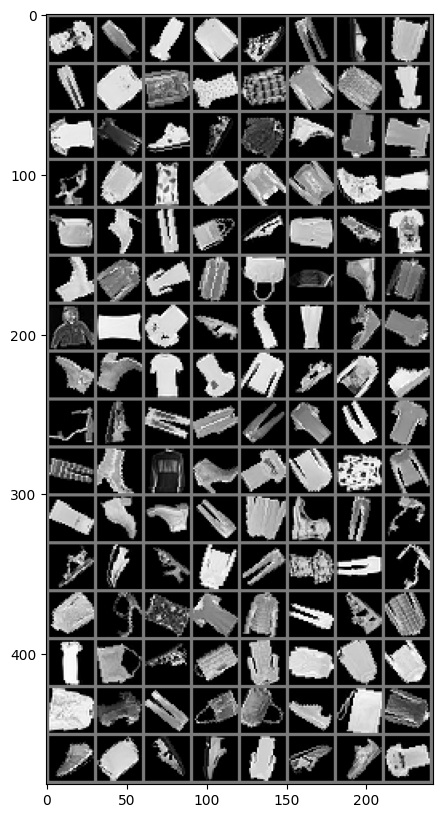

0 3 3 2 7 1 7 2 1 0 2 6 6 2 2 3 6 3 7 7 6 9 0 0 5 4 6 2 4 6 7 3 8 9 1 8 7 3 7 0 9 4 3 4 8 8 9 4 4 6 6 7 3 3 5 0 9 9 0 0 2 5 2 9 5 7 1 3 1 3 1 0 1 9 2 9 0 2 6 2 0 9 9 1 6 9 1 5 5 7 5 2 1 0 1 5 4 5 6 0 6 1 5 6 3 8 5 8 6 4 2 4 4 0 1 8 8 7 8 6 7 8 7 7 3 7 7 0
<class 'torch.utils.data.dataloader.DataLoader'>


In [ ]:
## Define a Pytorch Transforms Pipeline


mean=[0.485]
std=[0.229]
transforms_train = v2.Compose([
    #v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation([0,360]),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
])
transforms_test = v2.Compose(
    [
         #v2.RandomResizedCrop(size=(224, 224), antialias=True),
        v2.RandomHorizontalFlip(p=0.5),
        v2.RandomRotation([0,360]),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=mean, std=std),
    ]
)
batch_size=128
trainset = torchvision.datasets.FashionMNIST(root="./Data", train=True, transform=transforms_train, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

#
def load_data(batch_size=64):
  # Download and load the dataset
  train_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
  val_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

  # Create data loaders
  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

  return train_loader, val_loader
#
testset = torchvision.datasets.FashionMNIST(root="./Data", train=False, transform=transforms_test, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

# Load and Visualize a Transformed Image
def unnormalize(image, mean, std):
    mean = torch.tensor(mean).view(-1, 1, 1)
    print(mean.shape)
    std = torch.tensor(std).view(-1, 1, 1)
    return image * std + mean


def image_show(image):
    image = unnormalize(image, mean, std).numpy()
    image = np.transpose(image, (1, 2, 0))
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    axs.imshow(image)
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)
classes = np.arange(10)

# show images
img_grid = torchvision.utils.make_grid(images)
image_show(img_grid)
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(batch_size)))

print(type(trainloader))

#### 3. Make your own version of CNN and report the validatation set accuracy



In [ ]:
model = CNN()

def accuracy(loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            images, labels = data
            ypred = F.softmax(model(images))
            ypred = np.argmax(ypred, axis=1)
            total += labels.size(0)
            correct += (ypred == labels).sum()
    model.train()
    return  correct / total
print(accuracy(testloader))

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = self.fc1(x)

        return x
import torch.optim as optim

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 40 == 39:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            model.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(testloader, 0):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()

            model.train(True) # Switching back to training mode, eg. turning on regularisation
            avg_loss = running_loss / 40
            avg_vloss = running_vloss / len(testloader)
            print("Avg losses", avg_loss, avg_vloss)
            running_loss = 0.0

print('Finished Training')

# Let us now save the model state
#torch.save(model.state_dict(), './Models/model_weights.pth')

# You can then Load the model in the following manner
#model = CNN()
#model.load_state_dict(torch.load("./Models/model_weights.pth"))

print("Validation accuracy is: ", accuracy(testloader).item())



<ipython-input-7-67f058c43a13>:10: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


tensor(0.1236)
Batch 40
Avg losses 1.8943099796772003 1.6256426376632498
Batch 80
Avg losses 1.4533275544643403 1.3332009028784837
Batch 120
Avg losses 1.2977657794952393 1.2260212000412276
Batch 160
Avg losses 1.212003841996193 1.1926751038696193
Batch 200
Avg losses 1.164471310377121 1.1146264544016198
Batch 240
Avg losses 1.109045748412609 1.1398529749882371
Batch 280
Avg losses 1.1033243104815482 1.117905772939513
Batch 320
Avg losses 1.0809523239731789 1.0897104664693904
Batch 360
Avg losses 1.0355355083942412 1.0531092203116115
Batch 400
Avg losses 1.0333210691809653 1.0306760819652412
Batch 440
Avg losses 1.0243229672312737 1.0394620095627218
Batch 40
Avg losses 0.9713563844561577 1.003162089027936
Batch 80
Avg losses 0.9722209662199021 0.9714884810809847
Batch 120
Avg losses 0.9710813418030739 0.9646091702618177
Batch 160
Avg losses 0.9609979197382927 0.9658404053012027
Batch 200
Avg losses 0.9439436182379722 0.9541248301916485
Batch 240
Avg losses 0.9224840268492699 0.93338155

#### 4. Make 2 variations of CNNs (using different convolutions or pooling parameters) and compare them.



In [ ]:
# Variation 1
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = self.fc1(x)

        return x
import torch.optim as optim

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.01)

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 40 == 39:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            model.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(testloader, 0):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()

            model.train(True) # Switching back to training mode, eg. turning on regularisation
            avg_loss = running_loss / 40
            avg_vloss = running_vloss / len(testloader)
            print("Avg losses", avg_loss, avg_vloss)
            running_loss = 0.0

print('Finished Training')

# Let us now save the model state
#torch.save(model.state_dict(), './Models/model_weights.pth')

# You can then Load the model in the following manner
#model = CNN()
#model.load_state_dict(torch.load("./Models/model_weights.pth"))

print("Validation accuracy is: ", accuracy(testloader).item())


Batch 40
Avg losses 21.402081376314165 2.2830515994301326
Batch 80
Avg losses 2.268208146095276 2.271063264412216
Batch 120


KeyboardInterrupt: 

In [ ]:
# Variation 2
# Build a CNN
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(3,stride=2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.fc1 = nn.Linear(32 * 6 * 6, 10)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = self.fc1(x)

        return x
import torch.optim as optim
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 40 == 39:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            model.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(testloader, 0):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()

            model.train(True) # Switching back to training mode, eg. turning on regularisation
            avg_loss = running_loss / 40
            avg_vloss = running_vloss / len(testloader)
            print("Avg losses", avg_loss, avg_vloss)
            running_loss = 0.0

print('Finished Training')

# Let us now save the model state
#torch.save(model.state_dict(), './Models/model_weights.pth')

# You can then Load the model in the following manner
#model = CNN()
#model.load_state_dict(torch.load("./Models/model_weights.pth"))

print("Validation accuracy is: ", accuracy(testloader).item())

Batch 40
Avg losses 1.8650981873273849 1.537334083001825
Batch 80
Avg losses 1.4323618710041046 1.3214243544807918
Batch 120
Avg losses 1.2365535855293275 1.2455945769442787


KeyboardInterrupt: 

#### 5. Increase the number of Layers of the CNN (the number of convolutions followed by pooling layers) and observe what happens, in terms of the progress of the training and validation losses and the final model accuracies.



In [ ]:
from torchvision import transforms



class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.pool2 = nn.MaxPool2d(2)  # New pooling layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)  # New conv layer
        self.pool3 = nn.MaxPool2d(2)  # New pooling layer
        self.conv4=nn.Conv2d(64,128,3,padding=2)
        self.pool4=nn.AvgPool2d(2)
        self.fc1 = nn.Linear(128 * 2 * 2, 10)  # Adjusted input for final layer

    def forward(self, x):
        #print(x.shape)
        x = self.pool1(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        #print(x.shape)
        x = self.pool3(F.relu(self.conv3(x)))  # Pass through new layers
        #print(x.shape)
        x = self.pool4(F.relu(self.conv4(x)))
        #print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)

for epoch in range(5):  # loop over the dataset multiple times
    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 40 == 39:    # Every 1000 mini-batches...
            print('Batch {}'.format(i + 1))
            # Check against the validation set
            running_vloss = 0.0

            # In evaluation mode some model specific operations can be omitted eg. dropout layer
            model.train(False) # Switching to evaluation mode, eg. turning off regularisation
            for j, vdata in enumerate(testloader, 0):
                vinputs, vlabels = vdata
                voutputs = model(vinputs)
                vloss = criterion(voutputs, vlabels)
                running_vloss += vloss.item()

            model.train(True) # Switching back to training mode, eg. turning on regularisation
            avg_loss = running_loss / 40
            avg_vloss = running_vloss / len(testloader)
            print("Avg losses", avg_loss, avg_vloss)
            running_loss = 0.0

print('Finished Training')

# Let us now save the model state
#torch.save(model.state_dict(), './Models/model_weights.pth')

# You can then Load the model in the following manner
#model = CNN()
#model.load_state_dict(torch.load("./Models/model_weights.pth"))

print("Validation accuracy is: ", accuracy(testloader).item())

Batch 40
Avg losses 2.2310445666313172 2.1098255839528917
Batch 80
Avg losses 2.0026141077280046 1.960759638231012
Batch 120
Avg losses 1.741457188129425 1.531844597828539
Batch 160
Avg losses 1.4434078603982925 1.2934156248841104
Batch 200
Avg losses 1.2756110340356828 1.2046177787116812
Batch 240
Avg losses 1.150979520380497 1.190158711204046
Batch 280
Avg losses 1.0876652985811233 1.1175264693513702
Batch 320
Avg losses 1.0780267879366874 1.0738278310510176
Batch 360
Avg losses 1.0045035153627395 0.9689929530590395
Batch 400
Avg losses 0.9498304963111878 0.9403680306446703
Batch 440
Avg losses 0.940364845097065 0.9353507130960875
Batch 40
Avg losses 0.880106633901596 0.8967027339754226
Batch 80
Avg losses 0.8632778346538543 0.8951206629789328
Batch 120
Avg losses 0.8736956238746643 0.9188219248494015
Batch 160
Avg losses 0.8848961025476456 0.8584878897365136
Batch 200
Avg losses 0.8888870999217033 0.8210127293309079
Batch 240
Avg losses 0.8350731700658798 0.810779662071904
Batch 280

C:\Users\gregd\AppData\Local\Temp\ipykernel_24144\977417016.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.7736999988555908


#### 6. Visualize some of the Feature Maps and Convolution Kernels that you find interesting.

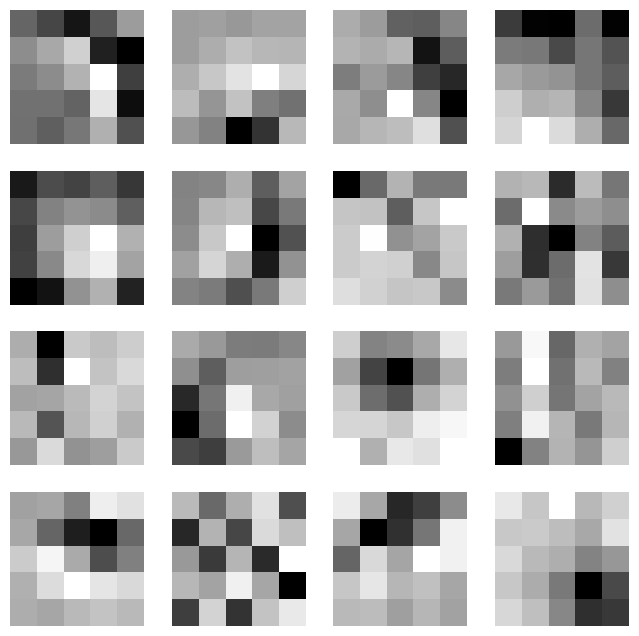

In [ ]:
# Let's visualize the feature maps
# Acquire an image
kernels = model.conv1.weight.detach()

# Move kernels to CPU if they are on GPU
kernels = kernels.cpu()

# Normalize kernels to [0,1] for visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

# Assuming you're dealing with a single input channel (e.g., grayscale images),
# you might want to visualize each output channel's kernel separately.
num_kernels = kernels.size(0)

# Set up the subplot dimensions
cols = int(np.sqrt(num_kernels))
rows = (num_kernels // cols) + (0 if num_kernels % cols == 0 else 1)

fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

for i, ax in enumerate(axs.flat):
    if i < num_kernels:
        # Select the i-th kernel, note that kernels[i].shape == [in_channels, H, W],
        # for grayscale (single channel inputs), it will be [1, H, W].
        # We squeeze it to [H, W] for visualization.
        kernel = kernels[i].squeeze()
        # For single-channel inputs, you can index as [0] to get the 2D kernel if in_channels > 1.
        # If your model works with multi-channel images (e.g., RGB), you'll need a strategy
        # to visualize these 3D kernels, such as showing each input channel's kernel separately.

        ax.imshow(kernel, cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

### **PART B: Transfer Learning**







#### 1. Load a Pretrained model (the simpler the better for computational efficiency e.g.resnet16). You are gonna use it to train your model on Fashion Mnist

In [ ]:
from torchvision import models

model = models.resnet18(pretrained=True)


c:\Users\gregd\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gregd\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### 2. Freeze the BackBone of the pretrained model (Convolutions etc) and modify the final fully connected layer/layers that perform classification (make sure the new output dimension matches the number of classes in Fashion Mnist)

In [ ]:

# Freeze model parameters (for feature extraction only, remove for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Unfreeze weights of the final layer (newly added for FashionMNIST)
for param in model.fc.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = model.fc.in_features
#model.fc = nn.Linear(num_ftrs, len(classes))  # Adapt to CIFAR-10

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### 3. Train the model on Fashion Mnist for a few epoches and log your train/val loss progress as well as the final model accuracy on the validation set.

In [ ]:
# Choose an optimizer (e.g., Adam) and loss function (e.g., CrossEntropyLoss)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:  # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 100:.3f}')
            running_loss = 0.0

print('Finished Training')

print(accuracy(testloader))

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[128, 1, 28, 28] to have 3 channels, but got 1 channels instead

#### **Optional:** If you are interested you can also unfreeze the final convolutions of the pretrained model to Fine Tune it. You can even visualize the Feature Maps of you model.

#### *Guidelines*: The goal of this assignment is that you play around a little bit with terms and notions introduced. You don' t have to train your models for ages. 5-10 epoches will suffice. We just want to see that you can make a model properly, train it and log some results.